## COMP3607 Recommender Systems Source Code (jjxc38)
# 📚 <b> BookBuddy </b> : Book Recommender System


- All Resources used are correctly referenced (IEEE) in the Video

\\
This jupyter notebook contains the source code for both the basic and advanced recommender systems I built
  - My Basic Implementation uses SVD Matrix Factorization
  - My Advanced Implementation uses a basic GNN (GraphSAGE)


# **Installs & Imports** ⚙️

- I used the suprise module for a built-in implementation of an SVD algorithm \\
- I used pytorch, torch-geometric, and the dgl modules to implement a GNN  \\
- I used numpy, pandas, and matplot-lib to handle tensors, matrices and chart data

In [ ]:
# installs
!pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html
!pip install scikit-surprise
!pip install torch
!pip install torch-geometric
!pip install openpyxl

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.dgl.ai/wheels/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.2 MB/s eta 0:00:00
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 51.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=a460dbcc059b20e

In [ ]:
# Standard library imports
import os
import re
import random
import time
import math

# Third-party imports for data handling and processing
import openpyxl
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing

# Visualization library
import matplotlib.pyplot as plt

# Machine learning and deep learning frameworks
import dgl
from dgl.nn import SAGEConv


import dgl.function as fn
from surprise import SVD, accuracy, Reader, Dataset
from surprise.model_selection import PredefinedKFold, KFold
from surprise.model_selection import train_test_split
from torch import nn, optim, Tensor
import torch
from torch_geometric.utils import degree, structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv import MessagePassing, gcn_conv
from torch_geometric.typing import Adj
from torch_geometric.nn.conv.gcn_conv import gcn_norm
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp


# Utility for progress bars
from tqdm.notebook import tqdm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# **General Data Preparation** 🛠️
- Used for both implementations
- <b>Key Steps</b>:
 - Convert the 'age' and 'year' columns to Integers & replace incorrect values with NaN in the users and books dataframes.

  - Drop Rows with NaN: Remove rows with NaN in 'age', 'year', and across all dataframes.

  - Filter Users and Books Based on Ratings: Keep only users and books that are present in ratings dataframe.

  - Filter Ratings for Existing Users and Books: Remove ratings with missing user IDs or book IDs.

  - Create Mappings for 'user_id' and 'book_id': Assign new sequential IDs to users and books.

  - Apply ID Mappings: Update 'user_id' and 'book_id' in users, books, and ratings with new IDs.




In [ ]:


try:

    # Read in ratings file
    ratings = pd.read_csv('book_dataset/Ratings.csv', sep=';', usecols=[0, 1, 2],
                          names=['user_id', 'book_id', 'rating'], header=0)

    # Read in users file
    users = pd.read_csv('book_dataset/Users.csv', sep=';', usecols=[0, 1],
                        names=['user_id', 'age'], header=0)

    # Read in books file
    books = pd.read_csv('book_dataset/Books.csv', sep=';', usecols=[0,1,3],
                        names=['book_id',  'title','year'], header=0)

    # Print the number of ratings, books, and users
    print(f"\nNumber of ratings: {ratings.shape[0]}")

    # Convert 'age' to integers, coerce errors to NaN
    users['age'] = pd.to_numeric(users['age'], errors='coerce')
    users.dropna(subset=['age'], inplace=True)

    # Convert 'year' to integers, coerce errors to NaN
    books['year'] = pd.to_numeric(books['year'], errors='coerce')


    # Remove rows with NaN values
    ratings.dropna(inplace=True)
    users.dropna(inplace=True)
    books.dropna(inplace=True)


    # Filter Out Users and Books Not in Ratings DataFrame
    # Keep only those users and books that have corresponding entries in the ratings data
    users_in_ratings = ratings['user_id'].unique()
    books_in_ratings = ratings['book_id'].unique()

    users = users[users['user_id'].isin(users_in_ratings)]
    books = books[books['book_id'].isin(books_in_ratings)]

    # Remove Ratings with Missing User or Book IDs
    ratings = ratings[ratings['user_id'].isin(users['user_id'])]
    ratings = ratings[ratings['book_id'].isin(books['book_id'])]

    users_in_ratings = ratings['user_id'].unique()
    books_in_ratings = ratings['book_id'].unique()

    users = users[users['user_id'].isin(users_in_ratings)]
    books = books[books['book_id'].isin(books_in_ratings)]


    # Create mappings for user_id and book_id
    user_id_mapping = {old: new for new, old in enumerate(sorted(users['user_id'].unique()))}


    # Determine the starting index for book_id mapping
    last_user_id = max(user_id_mapping.values()) + 1

    # Create book_id mapping starting from the last user_id + 1
    book_id_mapping = {old: new for new, old in enumerate(sorted(books['book_id'].unique()), start=last_user_id)}

    # Apply mappings to the dataframes
    users['user_id'] = users['user_id'].map(user_id_mapping)
    books['book_id'] = books['book_id'].map(book_id_mapping)
    ratings['user_id'] = ratings['user_id'].map(user_id_mapping)
    ratings['book_id'] = ratings['book_id'].map(book_id_mapping)

except Exception as e:
    print(f"An error occurred: {e}")
    print("Have you uploaded the dataset files? : https://grouplens.org/datasets/book-crossing/")



Number of ratings: 1149780


In [ ]:

# Print the first few rows for verification
print("Users DataFrame:")
print(users.head())
print("\nBooks DataFrame:")
print(books.head())
print("\nRatings DataFrame:")
print(ratings.head())

# Print the number of ratings, books, and users
print(f"\nNumber of ratings: {ratings.shape[0]}")
print(f"Number of books: {books.shape[0]}")
print(f"Number of users: {users.shape[0]}")


# Find the lowest and highest user IDs
lowest_user_id = min(user_id_mapping.values())
highest_user_id = max(user_id_mapping.values())

# Find the lowest and highest book IDs
lowest_book_id = min(book_id_mapping.values())
highest_book_id = max(book_id_mapping.values())


# Print the results
print(f"Lowest User ID: {lowest_user_id}")
print(f"Highest User ID: {highest_user_id}")
print(f"Lowest Book ID: {lowest_book_id}")
print(f"Highest Book ID: {highest_book_id}")


# Calculate the average rating
average_rating = ratings['rating'].mean()

# Calculate the 75th percentile (top 25%)
top_25_percent_rating = ratings['rating'].quantile(0.75)



print("Average Rating:", average_rating)
print("Top 25% Rating Threshold:", top_25_percent_rating)


num_users = ratings['user_id'].nunique()
num_books = ratings['book_id'].nunique()
num_ratings = len(ratings)

# Calculate the sparsity
sparsity = 1 - (num_ratings / (num_users * num_books))
print(f"Sparsity of the dataset: {sparsity:.4f}")

Users DataFrame:
    user_id   age
1         0  18.0
9         1  26.0
18        2  14.0
19        3  19.0
35        4  24.0

Books DataFrame:
   book_id                                              title  year
0    70872                                Classical Mythology  2002
1    50505                                       Clara Callan  2001
2    57107                               Decision in Normandy  1991
3   100770  Flu: The Story of the Great Influenza Pandemic...  1999
5   115211                             The Kitchen God's Wife  1991

Ratings DataFrame:
      user_id  book_id  rating
9561        0    70872       0
9584        1   245073       0
9600        2   102781       7
9601        3   118773       0
9612        4   167780       0

Number of ratings: 710045
Number of books: 222155
Number of users: 50454
Lowest User ID: 0
Highest User ID: 50453
Lowest Book ID: 50454
Highest Book ID: 272607
Average Rating: 2.7771775028343275
Top 25% Rating Threshold: 7.0
Sparsity of the d

# **RS1 – basic level: Personalised recommender system with conventional methods** ✅

- SVD - Probablisitc Matrix Factorization Algorithm, Ruslan Salakhutdinov and Andriy Mnih. Probabilistic matrix factorization. 2008. URL: https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf.

- Implemented using the 'suprise' module, URL: https://surprise.readthedocs.io/en/stable/index.html
---



In [ ]:
# Load the data into the suprise module
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings[["user_id", "book_id", "rating"]], reader)

In [ ]:

# Create the SVD algorithm
basic_algo = SVD()

# Split the data into training and test sets (90% training, 10% testing)
trainset, testset = train_test_split(data, test_size=0.1)

# Train the algorithm on the trainset
basic_algo.fit(trainset)

# Store predictions for later metric calculations
basic_predictions = basic_algo.test(testset)







# <b>RS2 – additional effort: Personalised recommender system with advanced method</b> ✅

- GNN - GraphSAGE, Inductive Representation Learning on Large Graphs, Will Hamilton, Zhitao Ying, Jure Leskovec. URL: https://proceedings.neurips.cc/paper_files/paper/2017/file/5dd9db5e033da9c6fb5ba83c7a7ebea9-Paper.pdf
- Implemented using the 'dgl' module, URL: https://docs.dgl.ai/




# **Advanced Data Preparation**  🛠️


- Turn ratings data into a graph (COO format)
  - a user and book only share an edge if there rating is >= the RATING_THRESHOLD
- Load graph data into dgl module
- Load implict data into graph (features)
- This graph is used to train the GNN (and is bipartite)




In [ ]:

# The threshold of what decides a 'good' rating
RATING_THRESHOLD = 7

# Convert DataFrame columns to lists
users_as_list = ratings['user_id'].tolist()
items_as_list = ratings['book_id'].tolist()
ratings_as_list = ratings['rating'].tolist()

# Create edges for the graph
edges = {'src': [], 'dst': []}
for user, item, rating in zip(users_as_list, items_as_list, ratings_as_list):
    if rating >= RATING_THRESHOLD:
        edges['src'].append(user)
        edges['dst'].append(item)

# Count unique users and books
unique_users = ratings['user_id'].nunique()

unique_books = ratings['book_id'].nunique()

# Calculate total number of nodes (assuming user IDs and book IDs are distinct)
total_nodes = unique_users + unique_books

# Create a bipartite graph
graph = dgl.graph((edges['src'], edges['dst']), num_nodes=total_nodes)


# Sort the users DataFrame by 'user_id'
sorted_users = users.sort_values(by='user_id')

# Sort the books DataFrame by 'book_id'
sorted_books = books.sort_values(by='book_id')


# Extract ages from the sorted users DataFrame
sorted_ages = sorted_users['age'].tolist()
sorted_ages = sorted_ages

# Extract years from the sorted books DataFrame
sorted_years = sorted_books['year'].tolist()
features = sorted_ages + sorted_years
features = torch.tensor(features[:-1]).unsqueeze(1)

# Number of features per node
number_of_features = 1

# Assign the random features to your graph
graph.ndata['feat'] = features

print("Number of nodes in the graph:", graph.number_of_nodes())


Number of nodes in the graph: 272608


# <b> Model Code </b> ✅

- Code that defines the model used to train the GNN and utility functions to construct the training & testing graphs.
- Using GraphSAGE a framework for inductive representation learning on large graphs


In [ ]:

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        # First GraphSAGE layer: transforms input features to hidden features
        self.conv1 = SAGEConv(in_feats, hidden_feats, 'mean')
        # Second GraphSAGE layer: transforms hidden features to output features
        self.conv2 = SAGEConv(hidden_feats, out_feats, 'mean')

    def forward(self, g, features):
        # Apply the first layer and use ReLU for non-linearity
        h = F.relu(self.conv1(g, features))
        # Apply the second layer to the output of the first layer
        h = self.conv2(g, h)
        return h

This model uses a dot product predictor to score how appropriate a book is to a user


In [ ]:
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # Use the graph's local scope to avoid modifying the graph
        with graph.local_scope():
            # Assign node features for the graph
            graph.ndata['h'] = h
            # Apply a dot product on the node features to compute edge scores
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # Return the computed scores stored in edge data
            return graph.edata['score']

In [ ]:

# Setting the user_id_threshold to the highest user ID - this is used to ensure that the negative graph formed is bipartite
# Ie ids that are above the user_id_threshold are known to be books
user_id_threshold = highest_user_id

# Function to construct a negative graph used as a negative example for training
def construct_negative_graph(graph, k):
    src, dst = graph.edges()  # Get the source and destination nodes of the graph
    neg_src = src.repeat_interleave(k)  # Repeat each source node k times for negative sampling

    neg_dst_list = []  # List to store the negative destination nodes

    # Loop over each source node to generate negative samples
    for s in src:
        if s < user_id_threshold:
            # For source nodes below the threshold, choose negative destinations from higher IDs
            neg_dst = torch.randint(user_id_threshold, graph.num_nodes(), (k,))
        else:
            # For source nodes above the threshold, choose negative destinations from lower IDs
            neg_dst = torch.randint(0, user_id_threshold, (k,))
        neg_dst_list.append(neg_dst)  # Append the negative destinations to the list

    neg_dst = torch.cat(neg_dst_list)  # Concatenate all negative destination nodes

    # Return a new graph with negative edges
    return dgl.graph((neg_src, neg_dst), num_nodes=graph.num_nodes())



In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        # Initialize the GraphSAGE layer with specified features
        self.sage = GraphSAGE(in_features, hidden_features, out_features)
        # Initialize the dot product predictor
        self.pred = DotProductPredictor()

    def forward(self, g, neg_g, x):
        # Apply GraphSAGE on the graph 'g' with features 'x'
        h = self.sage(g, x)
        # Return predictions for both the graph 'g' and the negative graph 'neg_g'
        return self.pred(g, h), self.pred(neg_g, h)

In [ ]:
# loss function
def compute_loss(pos_score, neg_score):
    # Margin loss
    n_edges = pos_score.shape[0]
    return (1 - pos_score + neg_score.view(n_edges, -1)).clamp(min=0).mean()


In [ ]:

u, v = graph.edges()

# Define edge IDs as a range from 0 to the number of edges - 1
eids = np.arange(graph.num_edges())

# Calculate the size of the test set as 10% of total edges - same split and used in basic recommender system
test_size = int(len(eids) * 0.1)

# Split edges for training and testing without shuffling
test_pos_u, test_pos_v = u[:test_size], v[:test_size]
train_pos_u, train_pos_v = u[test_size:], v[test_size:]

In [ ]:
# Create an adjacency matrix
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(graph.num_nodes(), graph.num_nodes()))
adj_dense = adj.todense()

# Create a matrix for negative samples
adj_neg = np.ones(adj_dense.shape) - adj_dense - np.eye(graph.num_nodes())

# Find all negative edges
neg_u, neg_v = np.where(adj_neg != 0)

# Sample negative edges
neg_eids = np.random.choice(len(neg_u), graph.num_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]


# Remove edges for training graph and test graph
train_g = dgl.remove_edges(graph, eids[:test_size])

test_g = dgl.remove_edges(graph, eids[test_size:])


<b>Training Loop 🚂</b>


In [ ]:

# Code for training
# Details discussed in Video
node_features = train_g.ndata['feat']  # Extract node features from the training graph
n_features = node_features.shape[1]    # Number of features per node
k = 5                                  # Number of negative samples per positive sample
model = Model(n_features, 512, 64)     # Initialize the model with specified feature dimensions

opt = torch.optim.Adam(model.parameters())  # Initialize the optimizer

# Training loop for 10 epochs
for epoch in range(10):
    # Construct a negative graph for each epoch
    negative_graph = construct_negative_graph(train_g, k)
    # Get positive and negative scores from the model
    pos_score, neg_score = model(train_g, negative_graph, node_features)
    # Compute the loss based on these scores
    loss = compute_loss(pos_score, neg_score)
    # Zero the gradients before backpropagation
    opt.zero_grad()
    # Backpropagate the error
    loss.backward()
    # Update model parameters
    opt.step()
    # Print the loss for this epoch
    print('LOSS: ', loss.item())


LOSS:  865.7496948242188
LOSS:  608.7073364257812
LOSS:  426.3106994628906
LOSS:  290.6559143066406
LOSS:  192.06539916992188
LOSS:  122.26351928710938
LOSS:  74.96351623535156
LOSS:  48.104095458984375
LOSS:  26.598684310913086
LOSS:  20.34558868408203


# <b> Prediction Code</b> 📖

- Defines the functions to predict 5 book reccomendations for a user
- Contains code used in demo - allowing user to input user_id and get recommendations

In [3]:
# functions to make predictions - used in UI

no_recommendations = 5

def RS1(user_id):
    # Check if the user exists
    user_exists = users['user_id'].isin([user_id]).any()
    if not user_exists:
        print("user does not exist")
        return None

    # Get unique book IDs
    book_ids = books['book_id'].unique()
    predictions = []

    # Generate predictions for each book
    for book_id in book_ids:
        prediction = basic_algo.predict(str(user_id), str(book_id))
        predictions.append((book_id, prediction.est))

    # Sort by estimated rating and select top N
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_predictions = predictions[:no_recommendations]

    # Get the titles of the top N books
    result = []
    for book_id, _ in top_predictions:
        book_title = books.loc[books['book_id'] == book_id, 'title'].iloc[0]
        result.append((book_title,book_id))
    return result

In [4]:
def RS2(user_id):

    # Check if the user exists
    user_exists = users['user_id'].isin([user_id]).any()
    if not user_exists:
        return None

    # Get unique book IDs
    book_ids = books['book_id'].unique()
    predictions = []

    user_embedding = node_embeddings[user_id]

    # Generate predictions for each book
    for book_id in book_ids:
        book_embedding = node_embeddings[book_id]
        predicted_rating = dot_product_predictor(user_embedding, book_embedding)
        predictions.append((book_id, predicted_rating))

    # Sort by estimated rating and select top N
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_predictions = predictions[:no_recommendations]

    # Get the titles of the top N books
    result = []
    for book_id, _ in top_predictions:
        book_title = books.loc[books['book_id'] == book_id, 'title'].iloc[0]
        result.append((book_title,book_id))

    return result

# <b> Evaluation Code</b> 👌

- Define the test dataset and utility functions so that the evaluation metrics can be calculated
- The first evaluation metric (chosen for the RS1 is <b>RMSE</b>)
- The second evaluation metric (chosen for the RS2 is <b>Novelty</b>)

In [ ]:
# Generate node embeddings for the test graph
node_embeddings = model.sage(test_g, node_features)

model.eval()

# Combine all node IDs from positive and negative test edges
test_node_ids = np.concatenate([test_pos_u, test_pos_v, test_neg_u, test_neg_v])

# Extract unique node IDs from the combined test node IDs to remove duplicates
unique_test_node_ids = np.unique(test_node_ids)


<b> Utility functions used for evaluation code </b>


In [ ]:
def normalize_and_scale_ratings(rating, min_rating, max_rating):
    # Normalize the rating to a 0-1 scale
    normalized_rating = (rating - min_rating) / (max_rating - min_rating)
    # Scale to a 1-10 range
    scaled_rating = normalized_rating * 9 + 1
    return scaled_rating

In [ ]:

def dot_product_predictor(embedding1, embedding2):
    return torch.dot(embedding1, embedding2)


In [ ]:
# Initialize lists for storing user IDs, book IDs, and predicted ratings
user_ids = []
book_ids = []
predicted_ratings = []

# Loop through each unique node ID in the test set
for node_id in unique_test_node_ids:
    # If the node ID is less than or equal to the highest user ID, it's a user ID
    if node_id <= highest_user_id:
        user_ids.append(node_id)
    else:
        # Otherwise, it's a book ID
        book_ids.append(node_id)

# Filter the 'ratings' DataFrame to include only rows with user IDs and book IDs from the test set
test_ratings = ratings[(ratings['user_id'].isin(user_ids)) & (ratings['book_id'].isin(book_ids))]

# Construct the test dataset from the filtered ratings DataFrame
# Each element in the dataset is a tuple (user_id, book_id, rating)
test_dataset = [(row['user_id'], row['book_id'], row['rating']) for _, row in test_ratings.iterrows()]
unique_user_ids = {user_id for user_id, _, _ in test_dataset}

# RMSE Evaluation Metric

The RMSE (Root Mean Square Error) is calculated as follows:

$$
\text{RMSE} = \sqrt{\frac{1}{|T|} \sum_{(u,i) \in T} (\hat{r}_{ui} - r_{ui})^2}
$$



In [ ]:
# Code to calculate the RMSE metric for the advanced method
def calculate_rmse_advanced():
    squared_errors = []
    # Calculate predicted ratings to find min and max
    for user_id, book_id, _ in test_dataset:
        user_embedding = node_embeddings[user_id]
        book_embedding = node_embeddings[book_id]
        predicted_rating = dot_product_predictor(user_embedding, book_embedding)
        predicted_ratings.append(predicted_rating)

    # Determine the scaling parameters
    min_predicted_rating = min(predicted_ratings)
    max_predicted_rating = max(predicted_ratings)

    # Calculate RMSE
    for user_id, book_id, actual_rating in test_dataset:
        user_embedding = node_embeddings[user_id]
        book_embedding = node_embeddings[book_id]

        predicted_rating = dot_product_predictor(user_embedding, book_embedding)
        scaled_rating = normalize_and_scale_ratings(predicted_rating, min_predicted_rating, max_predicted_rating)

        # Calculate the squared error
        squared_error = (scaled_rating - actual_rating) ** 2
        squared_errors.append(squared_error)

    # Compute mean of squared errors
    mse = sum(squared_errors) / len(squared_errors)

    # Calculate square root of MSE to get RMSE
    rmse = mse ** 0.5
    return rmse

# advanced RMSE calculation
advanced_rmse = calculate_rmse_advanced().item()
advanced_rmse = round(advanced_rmse, 3)



In [ ]:
# Code to calculate the RMSE metric for the basic method (we use the suprise modules built in method)
basic_rmse = accuracy.rmse(basic_predictions, verbose=True)
basic_rmse = round(basic_rmse, 3)


RMSE: 3.4981


In [ ]:
# print RMSE evaluation
print("BASIC RMSE (1st Evaluation Metric): ", basic_rmse)
print("ADVANCED RMSE (1st Evaluation Metric): ", advanced_rmse)


# Calculate the difference
rmse_difference = basic_rmse - advanced_rmse
rmse_difference = round(rmse_difference,3)
# Print the RMSE evaluation difference
print("Difference between BASIC and ADVANCED RMSE: ", rmse_difference)




BASIC RMSE (1st Evaluation Metric):  3.498
ADVANCED RMSE (1st Evaluation Metric):  3.162
Difference between BASIC and ADVANCED RMSE:  0.336


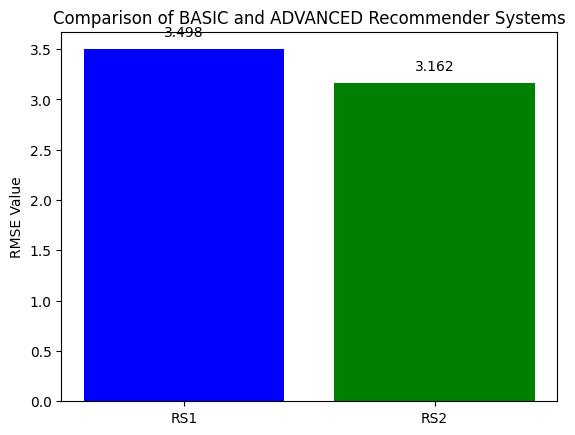

In [ ]:
# Creating a bar chart
labels = ['RS1', 'RS2']
values = [basic_rmse, advanced_rmse]

plt.bar(labels, values, color=['blue', 'green'])
plt.ylabel('RMSE Value')
plt.title('Comparison of BASIC and ADVANCED Recommender Systems')

# Displaying the values on the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

# Show the plot
plt.show()


# Novelty Evaluation Metric
-
$$
\text{Novelty}(R) = \frac{1}{|R|} \sum_{i \in R} -\log_2 p(i)
$$

In [ ]:
def calculate_novelty_basic(book_popularity, total_users):
    novelty_scores = []
    # Extract unique user IDs
    count = 0
    no = len(unique_user_ids)
    for user_id in unique_user_ids:
        count += 1
        # Get a list of 5 predictions
        predictions = RS1(user_id)

        # Calculate Novelty Score for each prediction
        user_novelty_scores = []
        for prediction in predictions:
            book_id = prediction[1]
            # Proportion of users who have rated/viewed the item
            p_i = book_popularity.get(book_id, 0) / total_users
            # Avoiding log of 0 by checking if p_i is greater than 0
            if p_i > 0:
                novelty_score = -math.log2(p_i)
            else:
                novelty_score = 0  # Assign a default value if p_i is 0
            user_novelty_scores.append(novelty_score)

        # Calculate the sum of the user's novelty scores and divide by the number of predictions
        if user_novelty_scores:
            novelty_scores.append(sum(user_novelty_scores) / len(user_novelty_scores))

    # Calculate the average of all novelty scores
    if novelty_scores:
        average_novelty = sum(novelty_scores) / len(novelty_scores)
    else:
        average_novelty = 0  # Handle case with no novelty scores

    return average_novelty

In [ ]:
def calculate_novelty_advanced(book_popularity, total_users):
    novelty_scores = []
    # Extract unique user IDs
    count = 0
    no = len(unique_user_ids)
    for user_id in unique_user_ids:
        count += 1
        # Get a list of 5 predictions
        predictions = RS2(user_id)

        # Calculate Novelty Score for each prediction
        user_novelty_scores = []
        for prediction in predictions:
            book_id = prediction[1]
            # Proportion of users who have rated/viewed the item
            p_i = book_popularity.get(book_id, 0) / total_users
            # Avoiding log of 0 by checking if p_i is greater than 0
            if p_i > 0:
                novelty_score = -math.log2(p_i)
            else:
                novelty_score = 0  # Assign a default value if p_i is 0
            user_novelty_scores.append(novelty_score)

        # Calculate the sum of the user's novelty scores and divide by the number of predictions
        if user_novelty_scores:
            novelty_scores.append(sum(user_novelty_scores) / len(user_novelty_scores))

    # Calculate the average of all novelty scores
    if novelty_scores:
        average_novelty = sum(novelty_scores) / len(novelty_scores)
    else:
        average_novelty = 0  # Handle case with no novelty scores

    return average_novelty

In [ ]:
# Form test set dataframe
test_set_df = pd.DataFrame(ratings, columns=['user_id', 'book_id', 'rating'])

# Calculate the total number of users
total_users = test_set_df['user_id'].nunique()
book_popularity = test_set_df['book_id'].value_counts().to_dict()

basic_novelty = calculate_novelty_basic(book_popularity, total_users)
advanced_novelty = calculate_novelty_advanced(book_popularity, total_users)

basic_novelty = round(basic_novelty,3)
advanced_novelty = round(advanced_novelty,3)


# print Novelty  evaluation
print("BASIC Novelty (2cnd Evaluation Metric): ", basic_novelty)
print("ADVANCED Novelty (2cnd Evaluation Metric): ", advanced_novelty)

# Calculate the difference
novelty_difference = round(abs(basic_novelty - advanced_novelty),3)

# Print the Novelty evaluation difference
print("Difference between BASIC and ADVANCED Novelty: ", novelty_difference)


BASIC Novelty (2cnd Evaluation Metric):  13.51
ADVANCED Novelty (2cnd Evaluation Metric):  14.742
Difference between BASIC and ADVANCED Novelty:  1.232


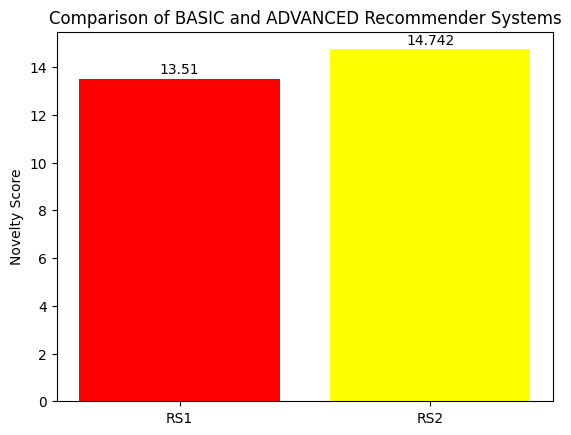

In [ ]:
# Creating a bar chart
labels = ['RS1', 'RS2']
values = [basic_novelty, advanced_novelty]

plt.bar(labels, values, color=['red', 'yellow'])
plt.ylabel('Novelty Score')
plt.title('Comparison of BASIC and ADVANCED Recommender Systems')

# Displaying the values on the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

# Show the plot
plt.show()

# <b>Demo Code</b> 🧑‍💻️

- Contains code used in demo - allowing user to input user_id and get recommendations


In [ ]:

predictions = []  # Initialize an empty list to store predictions

# Prompt the user to select a recommendation system (RS1 or RS2)
method = int(input("Enter '1' To use the RS1 or '2' to use RS2 "))

# Check if the entered method is not 1 or 2
if method != 1 and method != 2:
    # Print an error message and continue the loop for correct input
    print("You need to choose RS1 '1' or RS2 '2'")


# Prompt the user to enter a user ID for which predictions are to be made
user_id = int(input(f"Enter a user id to make predictions for "))

# Check which recommendation system to use based on the user's choice
if method == 1:
    predictions = RS1(user_id)  # Get predictions from RS1
else:
    predictions = RS2(user_id)  # Get predictions from RS2

if predictions != None or len(predictions) == 0:
  # Print each predicted title with its index
  for i, title in enumerate(predictions):
      print(" ")

      print(f'{i+1}. {title[0]}')


# End Of Code
All references in video